# 유사곡 추천 101 - 1. 데이터셋 얻기

### 데이터셋의 출처

* [Million Song Dataset](https://labrosa.ee.columbia.edu/millionsong/)
* [The Echo Nest Taste Profile Datset](https://labrosa.ee.columbia.edu/millionsong/tasteprofile)
* [AllMusic Genre Dataset](http://www.ifs.tuwien.ac.at/mir/msd/download.html)

### 데이터셋의 정보

The Echo Nest Taste Profile 데이터셋에는 `(USER, SONG, PLAY-COUNT)` 형태로 희소 행렬이 저장되어 있습니다.
[블로그](https://blog2.lucent.me/ml/music-recommender-systems-101-intro)에서 살펴보았던 형태와 똑같죠?
앞으로도 유저 정보를 활용한 접근을 다룰 때에는 이 데이터를 이용해서 코드를 작성할 예정입니다.

덧붙여, 이 데이터는 그대로 다루기엔 너무 크니까, 이렇게 줄여서 다루도록 합시다:

- 10,000곡
- 20,000유저

물론, 머신의 성능이 뛰어나다면 아래에서 파라미터만 바꾸어서 큰 실험을 할 수도 있습니다.

In [1]:
!curl -OL http://labrosa.ee.columbia.edu/millionsong/sites/default/files/challenge/train_triplets.txt.zip
!unzip train_triplets.txt.zip
!curl -OL http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/unique_tracks.txt
!curl -L https://labrosa.ee.columbia.edu/millionsong/sites/default/files/tasteprofile/sid_mismatches.txt | awk '{print substr($2, 2)}' > mismatches.txt
!curl -OL http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MASD-styleAssignment.cls
!curl -OL http://www.ifs.tuwien.ac.at/mir/msd/partitions/msd-MAGD-genreAssignment.cls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   368  100   368    0     0    399      0 --:--:-- --:--:-- --:--:--   399
100  488M  100  488M    0     0  1757k      0  0:04:44  0:04:44 --:--:-- 2055k  0     0  1857k      0  0:04:29  0:01:01  0:03:28 2301k4:37  0:01:46  0:02:51 1717k
Archive:  train_triplets.txt.zip
  inflating: train_triplets.txt      
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   369  100   369    0     0    192      0  0:00:01  0:00:01 --:--:--   192
100 80.1M  100 80.1M    0     0  1974k      0  0:00:41  0:00:41 --:--:-- 2306k      0  0:00:42  0:00:35  0:00:07 2172k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1978k  100 

##  메타데이터 읽기

In [2]:
import pandas as pd

In [3]:
tracks = pd.read_csv('unique_tracks.txt', sep='<SEP>', header=None, names=['track','song','artist','title'], engine='python')
tracks = tracks.set_index('track')
print(tracks.shape)
tracks.head()

(1000000, 3)


,song,artist,title
track,,,
TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


### 잘못된 엔트리 제거 (참고: [Matching Errors](https://labrosa.ee.columbia.edu/millionsong/blog/12-2-12-fixing-matching-errors))

In [4]:
mismatched = pd.read_csv('mismatches.txt', header=None, names=['song'])
tracks = tracks[tracks['song'].isin(mismatched['song']) == False]
tracks.shape

(981022, 3)

### 장르와 스타일 정보 추가

In [5]:
styles = pd.read_csv('msd-MASD-styleAssignment.cls', sep='\t', header=None, names=['track', 'style'], index_col='track')
genres = pd.read_csv('msd-MAGD-genreAssignment.cls', sep='\t', header=None, names=['track', 'genre'], index_col='track')
tracks = tracks.join(styles, on='track', how='left')
tracks = tracks.join(genres, on='track', how='left')
tracks.head()

,song,artist,title,style,genre
track,,,,,
TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night,NaN,NaN
TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan,NaN,NaN
TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever,Electronica,Electronic
TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés,NaN,International
TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens,NaN,NaN


## 플레이 카운트 행렬 읽기

In [6]:
play_counts = pd.read_table('train_triplets.txt', sep='\t', header=None, names=['user','song','count'])
play_counts = play_counts[play_counts.song.isin(mismatched.song) == False]  # 잘못된 엔트리 제거
print(play_counts.shape)
play_counts.head()

(48373586, 3)


,user,song,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


### 가장 많이 재생된(가장 유명한) k개의 노래 찾기 (k = 10,000)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')

데이터를 정리하는 김에, 한번 청취 횟수의 분포가 어떤지도 그려봅시다.
딱 예상 그대로의 롱테일 분포가 나옵니다. log10을 씌웠는데도 이 정도라니!

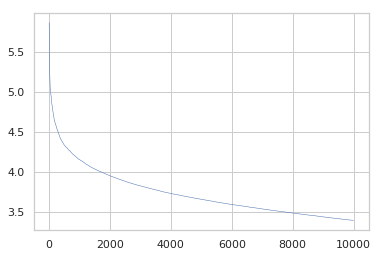

In [8]:
k = 10000
popular = play_counts.drop(columns='user').groupby(by='song').agg(sum).sort_values(by='count', ascending=False).head(k)
sns.lineplot(data=np.log10(popular['count'].values))

### 노래를 가장 많이 듣는 n명의 유저 찾기 (n = 20,000)

여기서는 위에서 얻은 k개의 노래에 대해서만 유저를 찾도록 합시다.

In [9]:
usable = play_counts[play_counts.song.isin(popular.index)]
usable.shape, len(usable.user.unique())

((25678977, 3), 1012431)

똑같이, 유저에 따른 청취 횟수도 한번 그려봅시다.
이건 정말 의외였는데, 위의 그래프와 비슷하게 롱테일 그래프가 나옵니다. 이건 좀 신기하네요.

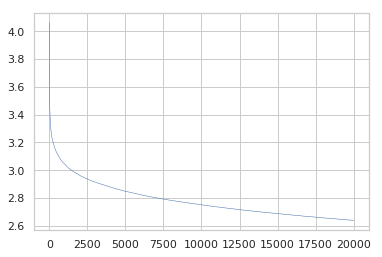

In [10]:
n = 20000
listener = usable.drop(columns='song').groupby('user').agg(sum).sort_values(by='count', ascending=False).head(n)
sns.lineplot(data=np.log10(listener['count'].values))

### 희소 행렬 만들기

이제 마지막 스텝으로, 위의 플레이 카운트 테이블을 다루기 쉬운 희소 행렬로 바꾸어 봅시다.

In [11]:
play_counts = play_counts[play_counts.user.isin(listener.index) & play_counts.song.isin(popular.index)]
print(play_counts.shape)
play_counts.head()

(2162215, 3)


,user,song,count
560,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFTRR12AF72A8D4D,1
561,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIILB12A58A776F7,3
563,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAJJDS12A8C13A3FB,1
565,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAKDHD12A6310F1AE,1
566,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMDXO12A8C131E2F,2


`pandas.Categorical`을 이용하면 `str`과 같은 다양한 형태의 데이터를 인덱스로 바꿀 수 있습니다.
비슷한 방법으로는 `scikit-learn`의 `LabelEncoder`가 있습니다. ([Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html), [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html))

In [12]:
import scipy.sparse as sparse
play_counts.user = play_counts.user.astype("category")
play_counts.song = play_counts.song.astype("category")
play_count_matrix = sparse.coo_matrix((play_counts['count'].values,
                                       (play_counts.song.cat.codes, play_counts.user.cat.codes)),
                                      shape=(k, n))
play_count_matrix

<10000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2162215 stored elements in COOrdinate format>

### 유효성 검증 (설마 아무도 안 들은 노래가 있다거나?)

다행히 없습니다. 휴!
만약 이런 곳에서 유효성 검증에 실패할 경우, 데이터를 뽑는 방법,
예를 들어 위에서 유저를 뽑는 방법을 다시 생각해 보아야 합니다.

In [13]:
assert(np.min(np.bincount(play_count_matrix.row)) > 0)

## 처리한 데이터셋 저장하기

전처리 한 데이터를 저장할 때에는,
다시 로드할 때 시간이 덜 걸리는 타입을 선택하는 것이 좋습니다.

In [14]:
tracks = tracks[tracks.song.isin(play_counts.song)]
tracks.song = pd.Categorical(tracks.song, categories=play_counts.song.cat.categories)
tracks['code'] = tracks.song.cat.codes
tracks = tracks.reset_index(level=0).set_index('code')
tracks.to_hdf('metadata.hdf', key='data', format='table')
sparse.save_npz('play_count_matrix.npz', play_count_matrix)